<a href="https://colab.research.google.com/github/mesh98a/DeepLearning/blob/main/LabN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mesh98a/DeepLearning
%cd DeepLearning

fatal: destination path 'DeepLearning' already exists and is not an empty directory.
/content/DeepLearning


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, Embedding, LSTM, GRU, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [3]:
df_train = pd.read_csv('Data/drugLibTrain_raw.tsv', delimiter='\t')
df_test = pd.read_csv('Data/drugLibTest_raw.tsv', delimiter='\t')

In [4]:
df_train.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


To make predictions based on reviews, all three columns are combined into one

In [5]:
def combine_reviews(df):
    return (
        df['benefitsReview'].fillna('') + ' ' +
        df['sideEffectsReview'].fillna('') + ' ' +
        df['commentsReview'].fillna('')
    )
X_train_text = combine_reviews(df_train)
X_test_text = combine_reviews(df_test)
print(X_train_text[0])



mangagement of congestive heart failur cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness monitor blood pressure , weight and asses for resolution of fluid


In the first case, we will determine the medication rating using binary classification. For this, all ratings less than or equal to 5 are converted to 0, and those above 5 are converted to 1

In [6]:
def split_rating(df):
    df['rating_category'] = np.where(df['rating'] <= 5, 0, 1)
    return df

df_train = split_rating(df_train)
df_test = split_rating(df_test)

y_train = df_train['rating_category']
y_test = df_test['rating_category']

In [7]:
df_train['rating_category'].value_counts() # class imbalance

,count
rating_category,
1,2287
0,820


Since models can only work with numbers, we need to convert text into numerical form. Using a tokenizer, we split the text into tokens (usually words) and assign them indices based on frequency, with 1 being the most frequent word.

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text)

vocab_size = len(tokenizer.word_index)

print(tokenizer.index_word)
print(f"Vocabulary size: {vocab_size}")

{1: 'i', 2: 'the', 3: 'to', 4: 'and', 5: 'a', 6: 'of', 7: 'my', 8: 'it', 9: 'was', 10: 'in', 11: 'for', 12: 'that', 13: 'have', 14: 'with', 15: 'not', 16: 'this', 17: 'on', 18: 'had', 19: 'but', 20: 'is', 21: 'as', 22: 'me', 23: 'after', 24: 'at', 25: 'day', 26: 'side', 27: 'effects', 28: 'take', 29: 'taking', 30: 'no', 31: 'or', 32: 'drug', 33: 'so', 34: 'pain', 35: 'very', 36: 'be', 37: 'when', 38: 'more', 39: 'medication', 40: 'did', 41: 'were', 42: 'from', 43: 'would', 44: '\r\r', 45: 'time', 46: 'also', 47: 'one', 48: 'if', 49: 'about', 50: 'up', 51: 'am', 52: 'treatment', 53: 'which', 54: 'all', 55: 'days', 56: 'skin', 57: 'took', 58: '2', 59: 'been', 60: 'an', 61: 'only', 62: 'first', 63: 'any', 64: 'has', 65: 'years', 66: 'before', 67: 'then', 68: 'mg', 69: 'get', 70: 'sleep', 71: 'you', 72: 'by', 73: 'some', 74: 'started', 75: 'feel', 76: 'like', 77: 'months', 78: 'night', 79: '3', 80: 'are', 81: 'weeks', 82: 'there', 83: 'felt', 84: 'dose', 85: 'other', 86: 'once', 87: 'out',

The next step is converting the text into numerical sequences and bringing them to the same length.

In [9]:
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

Next come classification metrics to evaluate the performance of our model during training

In [10]:
def evaluate_model(model, history, X_test, y_test, is_binary=True):

    # Predictions
    y_pred_probs = model.predict(X_test)
    if is_binary:
        y_pred = (y_pred_probs > 0.5).astype(int) # [0,1]
    else:
        y_pred = np.argmax(y_pred_probs, axis=1) # [0,1,2]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc = roc_auc_score(y_test, y_pred_probs) if is_binary else roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.3f}")
    print(f"Balanced Accuracy: {bal_acc:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC AUC: {roc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot Loss Curve
    if 'loss' in history.history:
        plt.plot(history.history['loss'], color='blue', label='Train Loss')
        plt.plot(history.history['val_loss'], color='red', label='Validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


In our binary classification task based on text reviews, we use several key components.

First, we apply an Embedding layer to convert words into dense vector representations. This is necessary so the model can work with numerical features rather than raw text, capturing semantic relationships between words.

Next, we use a Bidirectional RNN, which allows the model to analyze both the previous and the next context of each word in the sentence. This is especially important for understanding the meaning of phrases within the text.

At the output, we use a layer with a sigmoid activation function, which returns the probability that a review belongs to the positive class.

Since the dataset may be imbalanced (e.g., more positive reviews than negative ones), we also use compute_class_weight to automatically adjust class weights, helping the model to fairly learn both classes

In [21]:
def train_binary_model(model_name, RNNLayer):
    print(f"Training: {model_name}")
    model = Sequential([
        Embedding(vocab_size + 1, 100),
        Bidirectional(RNNLayer(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(RNNLayer(64)), # second layer
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=128, validation_data =(X_test_pad,y_test), class_weight=class_weights, verbose=1)

    evaluate_model(model, history, X_test_pad, y_test, is_binary=True)


Training: SimpleRNN
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - accuracy: 0.5330 - loss: 0.7204 - val_accuracy: 0.5280 - val_loss: 0.6902
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6510 - loss: 0.6451 - val_accuracy: 0.4981 - val_loss: 0.7395
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8103 - loss: 0.4266 - val_accuracy: 0.5531 - val_loss: 0.7925
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9794 - loss: 0.1169 - val_accuracy: 0.5849 - val_loss: 0.9520
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9959 - loss: 0.0294 - val_accuracy: 0.5811 - val_loss: 1.0969
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9997 - loss: 0.0096 - val_accuracy: 0.6014 - val_loss: 1.0969
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.5956 - val_loss: 1.1462
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 0.0027 - va

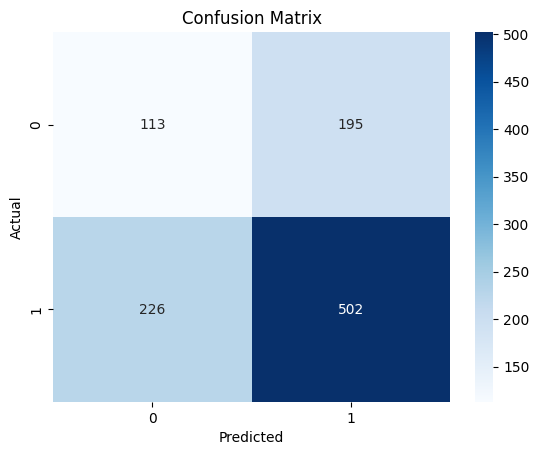

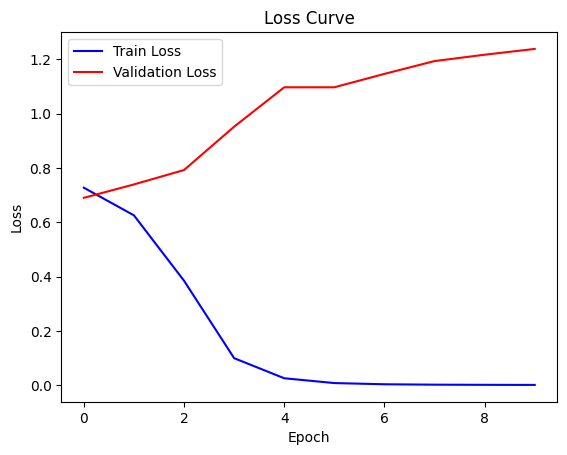

In [22]:
train_binary_model("SimpleRNN", SimpleRNN)

Training: LSTM
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.3680 - loss: 0.7042 - val_accuracy: 0.6535 - val_loss: 0.6250
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6869 - loss: 0.5699 - val_accuracy: 0.6998 - val_loss: 0.5887
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8726 - loss: 0.3400 - val_accuracy: 0.7461 - val_loss: 0.5606
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9527 - loss: 0.1613 - val_accuracy: 0.7548 - val_loss: 0.7080
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9865 - loss: 0.0548 - val_accuracy: 0.7510 - val_loss: 0.8689
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9925 - loss: 0.0282 - val_accuracy: 0.7394 - val_loss: 0.9014
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9965 - loss: 0.0180 - val_accuracy: 0.7307 - val_loss: 1.0964
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9893 - loss: 0.0318 - val_accuracy: 0.7452 - val_loss: 1.

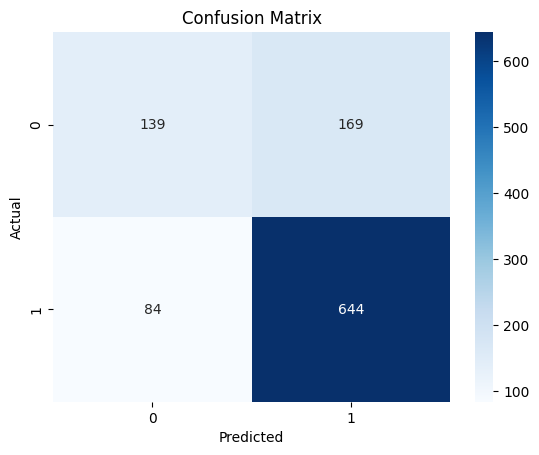

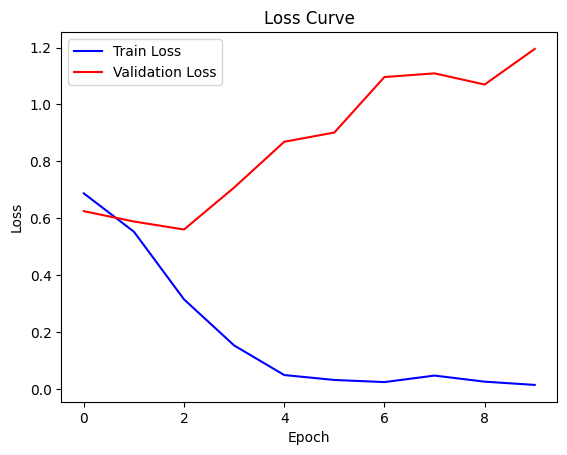

In [13]:
train_binary_model("LSTM", LSTM)

Training: GRU
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.6738 - loss: 0.6836 - val_accuracy: 0.3263 - val_loss: 0.7145
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5751 - loss: 0.6473 - val_accuracy: 0.6458 - val_loss: 0.6364
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8059 - loss: 0.4137 - val_accuracy: 0.6438 - val_loss: 0.7856
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9267 - loss: 0.1887 - val_accuracy: 0.6313 - val_loss: 1.0391
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9646 - loss: 0.0995 - val_accuracy: 0.6766 - val_loss: 1.1501
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9916 - loss: 0.0426 - val_accuracy: 0.6969 - val_loss: 1.4778
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9944 - loss: 0.0218 - val_accuracy: 0.6853 - val_loss: 1.5433
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9981 - loss: 0.0086 - val_accuracy: 0.6969 - val_loss: 1.

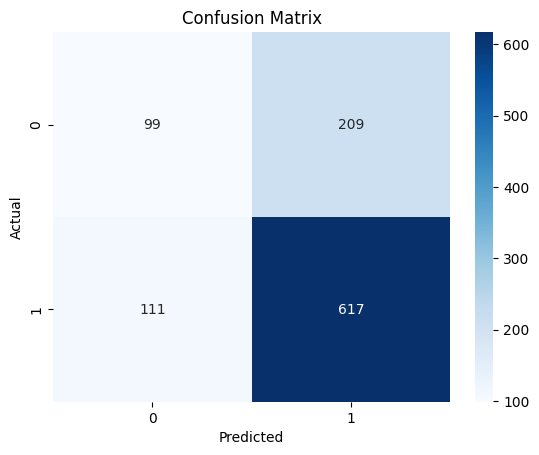

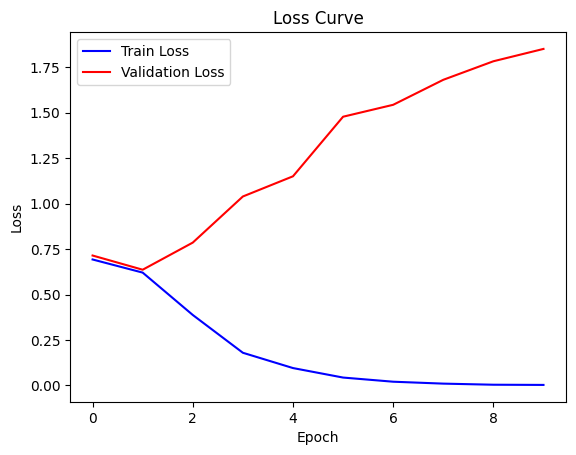

In [14]:
train_binary_model("GRU", GRU)

Multiclassification (Effectiveness)
We reduce the number of classes to three levels of effectiveness: Low, Moderate, and High.

In [15]:
def map_effectiveness(x):
    if x in ['Highly Effective', 'Considerably Effective']:
        return 'High'
    elif x in ['Moderately Effective', 'Marginally Effective']:
        return 'Moderate'
    else:
        return 'Low'

eff_map = {'Low': 0, 'Moderate': 1, 'High': 2}

df_train['eff_label'] = df_train['effectiveness'].apply(map_effectiveness).map(eff_map)
df_test['eff_label'] = df_test['effectiveness'].apply(map_effectiveness).map(eff_map)
df_train['eff_label'].value_counts()

,count
eff_label,
2,2258
1,602
0,247


The effectiveness labels (eff_label), encoded as integers 0, 1, and 2, are converted into one-hot encoded vectors using to_categorical.
This means each label becomes a vector of length 3, with a 1 at the position of the class index and 0s elsewhere.
This format is required for training models on multiclass classification tasks

In [16]:
y_train_eff = df_train['eff_label']
y_test_eff = df_test['eff_label']
y_train_eff_cat = to_categorical(df_train['eff_label'], num_classes=3)
y_test_eff_cat = to_categorical(df_test['eff_label'], num_classes=3)

print(y_train_eff[0])
print(y_train_eff_cat[0])

2
[0. 0. 1.]


In [17]:
y_test_labels = df_test['eff_label'].values

In this multiclass classification task we use a sequential neural model.

We also use an Embedding layer and a Bidirectional RNN. In this case, dropout parameters are applied within the Bidirectional RNN to reduce overfitting. Additionally, a separate Dropout layer is added, which randomly deactivates some neurons during training to further prevent overfitting.

The output layer is a Dense layer with softmax activation, which returns probabilities for each of the three classes.

In [24]:
def train_multiclass_model(name, RNNLayer):
    print(f"Training Multiclass: {name}")
    model = Sequential([
        Embedding(vocab_size + 1, 100),
        #Bidirectional(RNNLayer(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        Bidirectional(RNNLayer(64,dropout=0.3, recurrent_dropout=0.2)),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_pad, y_train_eff_cat, epochs=10, batch_size=128, validation_data =(X_test_pad,y_test_eff_cat) ,verbose=1)

    y_pred = np.argmax(model.predict(X_test_pad), axis=1)

    evaluate_model(model, history, X_test_pad, y_test_labels, is_binary=False)


Training Multiclass: SimpleRNN Effectiveness
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step - accuracy: 0.3877 - loss: 1.1521 - val_accuracy: 0.6815 - val_loss: 0.8393
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6096 - loss: 0.9032 - val_accuracy: 0.6959 - val_loss: 0.8196
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6739 - loss: 0.8665 - val_accuracy: 0.6959 - val_loss: 0.8277
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7002 - loss: 0.8392 - val_accuracy: 0.6959 - val_loss: 0.8193
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7081 - loss: 0.8260 - val_accuracy: 0.6959 - val_loss: 0.8224
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6946 - loss: 0.8215 - val_accuracy: 0.6959 - val_loss: 0.8353
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7076 - loss: 0.7995 - val_accuracy: 0.6959 - val_loss: 0.8424
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.696
Balanced Accuracy: 0.333
F1 Score: 0.571
ROC AUC: 0.517
Precision: 0.484
Recall: 0.696


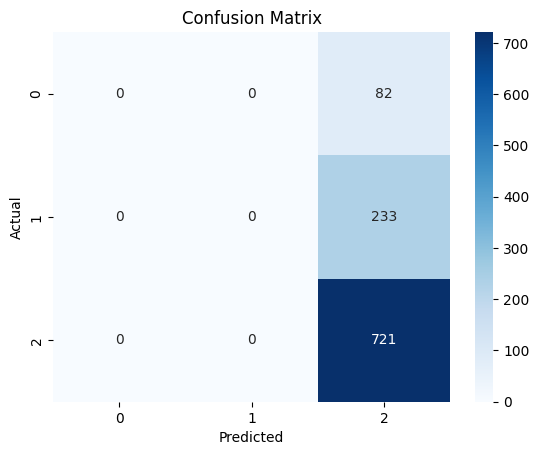

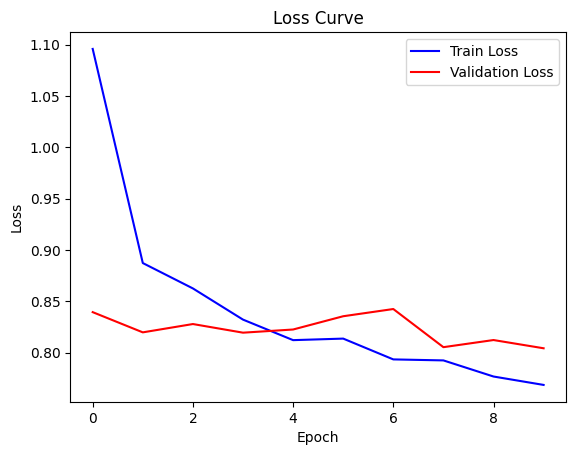

In [25]:
train_multiclass_model("SimpleRNN Effectiveness", SimpleRNN)

Training Multiclass: LSTM Effectiveness
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6532 - loss: 0.9130 - val_accuracy: 0.6959 - val_loss: 0.7944
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7198 - loss: 0.7612 - val_accuracy: 0.6959 - val_loss: 0.7947
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7228 - loss: 0.7107 - val_accuracy: 0.6959 - val_loss: 0.8118
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7512 - loss: 0.6017 - val_accuracy: 0.6689 - val_loss: 0.7779
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7943 - loss: 0.5017 - val_accuracy: 0.6931 - val_loss: 0.8983
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8414 - loss: 0.3865 - val_accuracy: 0.6757 - val_loss: 0.9501
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8715 - loss: 0.3215 - val_accuracy: 0.6361 - val_loss: 0.9922
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8918 - loss: 0.2795 - val_accuracy: 0.6795 - val_loss: 1.2042
Epo

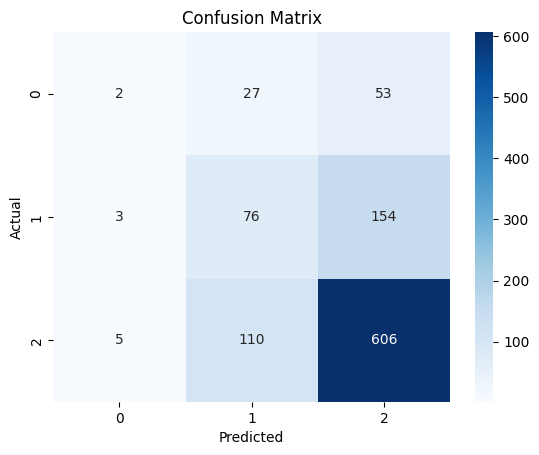

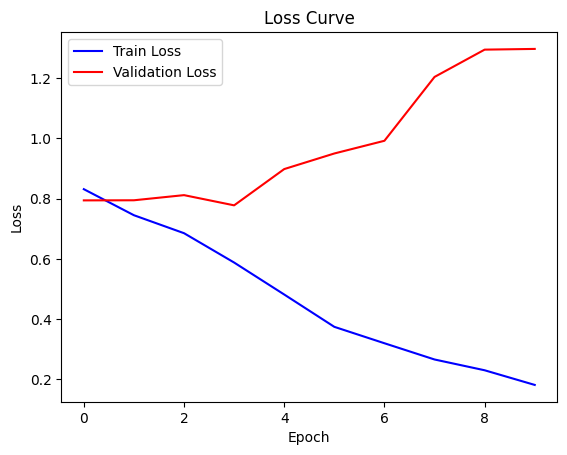

In [23]:
train_multiclass_model("LSTM Effectiveness", LSTM)

Training Multiclass: GRU Effectiveness
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6471 - loss: 0.9306 - val_accuracy: 0.6959 - val_loss: 0.7986
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7247 - loss: 0.7529 - val_accuracy: 0.6959 - val_loss: 0.7851
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7272 - loss: 0.7015 - val_accuracy: 0.6959 - val_loss: 0.7748
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7324 - loss: 0.6085 - val_accuracy: 0.6786 - val_loss: 0.8157
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8150 - loss: 0.4578 - val_accuracy: 0.6583 - val_loss: 0.9424
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8711 - loss: 0.3338 - val_accuracy: 0.6535 - val_loss: 1.1213
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8881 - loss: 0.2842 - val_accuracy: 0.6361 - val_loss: 1.1712
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9222 - loss: 0.

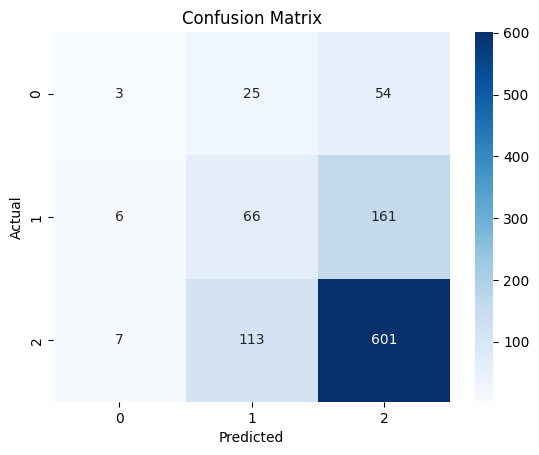

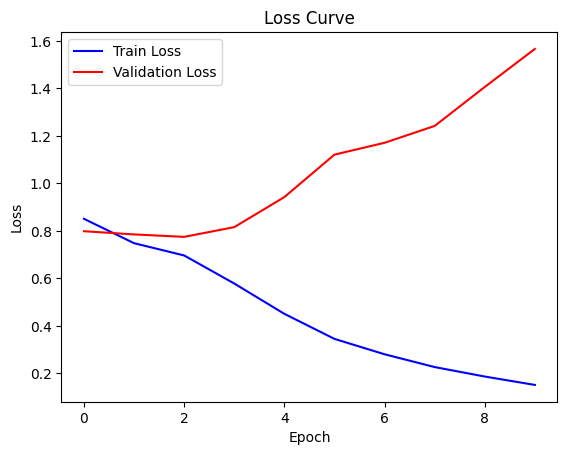

In [26]:
train_multiclass_model("GRU Effectiveness", GRU)

In conclusion, when comparing RNN, LSTM, and GRU architectures, LSTM tends to perform better due to its more complex structure, including additional gates that allow it to better control the flow of information. This makes it more effective at capturing long-term dependencies in text. However, despite this advantage, the overall model performance remains modest — with LSTM achieving around 65% accuracy, it still misclassifies approximately 35% of the cases. Additionally, the model shows signs of overfitting, learning the training data well but struggling to generalize to new, unseen data.

This performance limitation may be attributed to several factors: limited or imbalanced training data, noisy or unstructured text (e.g., spelling errors, informal language), insufficient preprocessing, overly simple model architecture, or the use of randomly initialized embeddings rather than pretrained ones.

To improve results, several strategies could be applied: incorporating pretrained word embeddings (such as GloVe or Word2Vec),, expanding and cleaning the dataset, applying regularization techniques (like dropout or L2), fine-tuning hyperparameters, and ensuring stratified sampling to preserve class balance during training. These enhancements could help the model generalize better and increase classification performance